In [1]:
pwd

'C:\\Users\\kikku\\brain'

In [7]:
import import_ipynb
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import json
import cv2
import h5py
import imageio
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")

ModuleNotFoundError: No module named 'cv2'

In [8]:
import numpy as np
import nibabel as nib                                                     # Read / write access to some common neuroimaging file formats
import itk                                                                # Jupyter widgets to visualize images in 2D and 3D
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [12]:
# Define the image path and load the data
image_path = "./data/images/BRATS_001.nii.gz"
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


In [13]:
# Extract data as numpy ndarray
image_data = image_obj.get_fdata()
type(image_data)

numpy.ndarray

In [14]:
height, width, depth, channels = image_data.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}, channels:{channels}")

The image object has the following dimensions: height: 240, width:240, depth:155, channels:4


Plotting Layer 119 Channel 0 of Image


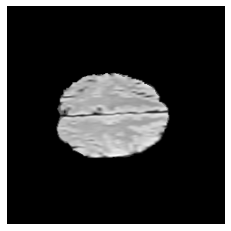

In [15]:
# Select random layer number
maxval = 154
i = np.random.randint(0, maxval)
# Define a channel to look at
channel = 0
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.imshow(image_data[:, :, i, channel], cmap='gray')
plt.axis('off');

In [16]:
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(image_data[:, :, layer, channel], cmap='gray');
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer
    
# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [17]:
label_path = "./data/labels/BRATS_001.nii.gz"
label_obj = nib.load(label_path)
type(label_obj)

nibabel.nifti1.Nifti1Image

In [18]:
# Extract data labels
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [19]:
# Extract and print out the shape of the labels data
height, width, depth = label_array.shape
print(f"Dimensions of labels data array height: {height}, width: {width}, depth: {depth}")
print(f'With the unique values: {np.unique(label_array)}')
print("""Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor""")

Dimensions of labels data array height: 240, width: 240, depth: 155
With the unique values: [0. 1. 2. 3.]
Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor


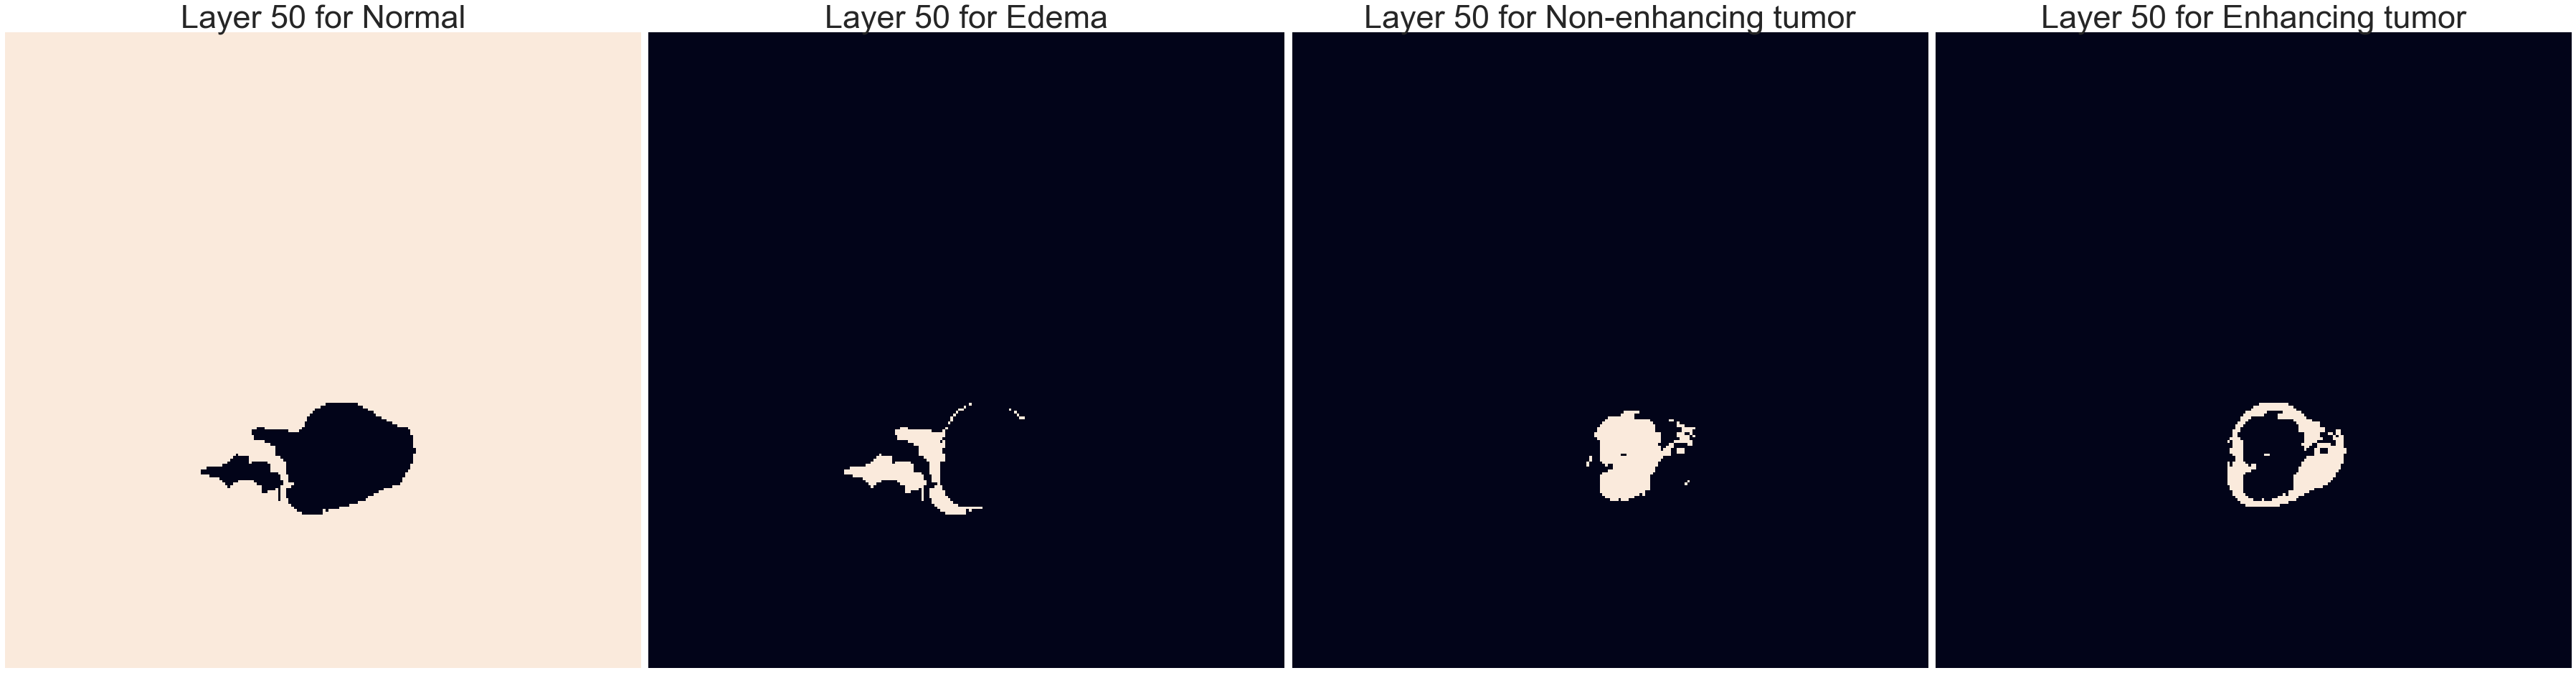

In [20]:
layer = 50
# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}
# Set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

In [23]:
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info', 
    
)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)

    
# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…